In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HousePricePrediction") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "100") \
    .getOrCreate()

In [2]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'files'
train_path = str(DATA_DIR / "train.csv")
test_path  = str(DATA_DIR/"test.csv")

train_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")   # 关键：自动推断数值类型
            .option("nullValue", "NA")       # 可选：明确 NA 为 null
            .csv(train_path))

test_df = (spark.read
           .option("header", "true")
           .option("inferSchema", "true")
           .option("nullValue", "NA")
           .csv(test_path))

print("=== Train Schema ===")
train_df.printSchema()
print(f"Train rows: {train_df.count()}, cols: {len(train_df.columns)}")

print("\n=== Test Schema ===")
test_df.printSchema()

=== Train Schema ===
root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string 

In [3]:
# === 区分列类型（基于实际 schema）===

from pyspark.sql.types import IntegerType, DoubleType, StringType

num_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, (IntegerType, DoubleType))
            and field.name != "SalePrice"]

cat_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, StringType)]

print(f"数值列 ({len(num_cols)}): {num_cols[:10]}...")
print(f"类别列 ({len(cat_cols)}): {cat_cols[:10]}...")

数值列 (37): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']...
类别列 (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...


In [4]:
from pyspark.sql import functions as F
# === 数值列：中位数填补 ===
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy="median")

# 分别 fit，避免 train/test 统计泄露
train_df = imputer.fit(train_df).transform(train_df)
test_df  = imputer.fit(test_df).transform(test_df)

# === 类别列：缺失值填 "Missing" ===
for c in cat_cols:
    train_df = train_df.fillna({c: "Missing"})
    test_df  = test_df.fillna({c: "Missing"})

# 验证无缺失
print("数值列缺失统计:")
train_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in num_cols]).show()

数值列缺失统计:
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+-----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageYrBlt|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+---

In [5]:
# === 类别编码：StringIndexer + OneHotEncoder ===
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in cat_cols
]

encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec", handleInvalid="keep")
    for c in cat_cols
]

# 数值特征标准化
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler_num = VectorAssembler(inputCols=num_cols, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num", withStd=True, withMean=True)

# 最终特征向量
feature_cols = [c + "_vec" for c in cat_cols] + ["scaled_num"]
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 目标：对 SalePrice 取 log
import pyspark.sql.functions as F
train_df = train_df.withColumn("logSalePrice", F.log1p(F.col("SalePrice")))
target_col = "logSalePrice"

In [6]:
# === 构建完整 Pipeline ===
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target_col,
    numTrees=500,
    maxDepth=12,
    subsamplingRate=0.8,
    seed=42
)

pipeline_rf = Pipeline(stages=indexers + encoders + [assembler_num, scaler, final_assembler, rf])

In [7]:
train_set, val_set = train_df.randomSplit([0.8, 0.2], seed=42)

model_rf = pipeline_rf.fit(train_set)
pred_rf = model_rf.transform(val_set)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
rmse_rf = evaluator.evaluate(pred_rf)
r2_rf = RegressionEvaluator(labelCol=target_col, metricName="r2").evaluate(pred_rf)
print(f"RF RMSE (log): {rmse_rf:.4f}, R²: {r2_rf:.4f}")

RF RMSE (log): 0.1238, R²: 0.8983


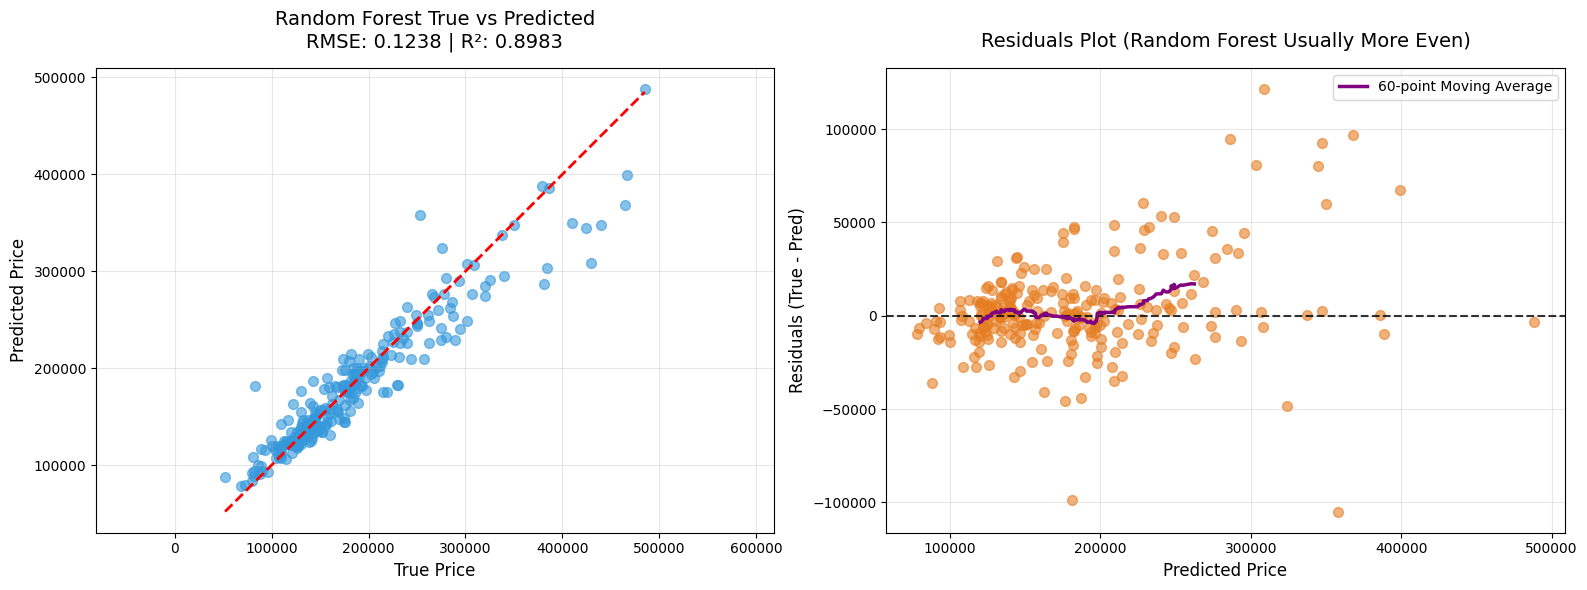

In [9]:
# ============== 5 真实值 vs 预测值 + 残差图（Random Forest）==============
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pred_pd = pred_rf.select("logSalePrice", "prediction").toPandas()
pred_pd["TruePrice"] = np.expm1(pred_pd["logSalePrice"])
pred_pd["PredPrice"] = np.expm1(pred_pd["prediction"])
residuals = pred_pd["TruePrice"] - pred_pd["PredPrice"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：真实 vs 预测
ax1.scatter(pred_pd["TruePrice"], pred_pd["PredPrice"], alpha=0.6, c="#3498db", s=50)
ax1.plot([pred_pd["TruePrice"].min(), pred_pd["TruePrice"].max()],
         [pred_pd["TruePrice"].min(), pred_pd["TruePrice"].max()], 'r--', lw=2)
ax1.set_xlabel("True Price", fontsize=12)
ax1.set_ylabel("Predicted Price", fontsize=12)
ax1.set_title(f"Random Forest True vs Predicted\nRMSE: {rmse_rf:.4f} | R²: {r2_rf:.4f}", fontsize=14, pad=15)
ax1.axis("equal")
ax1.grid(True, alpha=0.3)

# 右图：残差图（带移动平均趋势线，无需 statsmodels）
ax2.scatter(pred_pd["PredPrice"], residuals, alpha=0.6, c="#e67e22", s=50)
ax2.axhline(0, color="black", linestyle="--", alpha=0.8)
ax2.set_xlabel("Predicted Price", fontsize=12)
ax2.set_ylabel("Residuals (True - Pred)", fontsize=12)
ax2.set_title("Residuals Plot (Random Forest Usually More Even)", fontsize=14, pad=15)

# 添加平滑趋势线（移动平均）
sorted_idx = pred_pd["PredPrice"].argsort()
sorted_pred = pred_pd["PredPrice"].iloc[sorted_idx].values
sorted_res = residuals.iloc[sorted_idx].values
window = 60
import pandas as pd
rolling = pd.Series(sorted_res).rolling(window=window, center=True).mean()
ax2.plot(sorted_pred, rolling, color="purple", lw=2.5, label=f"{window}-point Moving Average")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\李一\AppData\Local\Temp\ipykernel_15776\342727061.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x="importance", y="feature", palette="rocket")


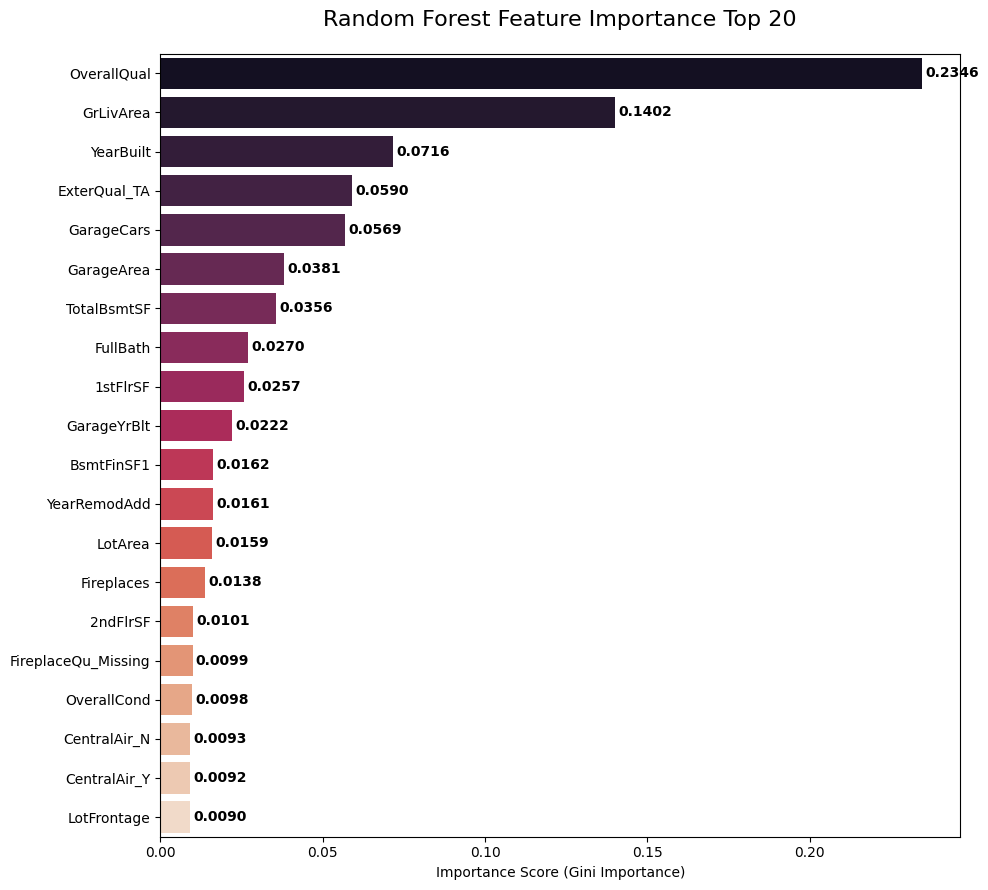

Random Forest Top 10 Most Important Features:


,feature,importance
309,OverallQual,0.234578
321,GrLivArea,0.140162
311,YearBuilt,0.071564
147,ExterQual_TA,0.059035
331,GarageCars,0.056942
332,GarageArea,0.038120
317,TotalBsmtSF,0.035593
324,FullBath,0.026986
318,1stFlrSF,0.025705
330,GarageYrBlt,0.022207


In [11]:
# ============== 6 Random Forest 特征重要性 Top 20（带真实特征名）==============
from pyspark.ml.regression import RandomForestRegressionModel
import pandas as pd

# 取出训练好的 RF 模型
rf_model = model_rf.stages[-1]
assert isinstance(rf_model, RandomForestRegressionModel)

importances = rf_model.featureImportances.toArray()

# 重建完整特征名（严谨版，和之前 LR/GBT 完全一致）
feature_names = []
transformer_stages = model_rf.stages[:-1]  # 排除最后的 RF

for stage in transformer_stages:
    # StringIndexer 阶段
    if hasattr(stage, "getOutputCol") and stage.getOutputCol().endswith("_idx"):
        col_name = stage.getOutputCol()[:-4]  # 去掉 _idx
        labels = list(stage.labels) + ["OOV"]  # handleInvalid="keep"
        feature_names.extend([f"{col_name}_{label}" for label in labels])
    # 标准化后的数值特征
    elif hasattr(stage, "getOutputCol") and stage.getOutputCol() == "scaled_num":
        feature_names.extend(num_cols)

# 构造 DataFrame 并绘图
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 9))
top20 = imp_df.head(20)
sns.barplot(data=top20, x="importance", y="feature", palette="rocket")
plt.title("Random Forest Feature Importance Top 20", fontsize=16, pad=20)
plt.xlabel("Importance Score (Gini Importance)")
plt.ylabel("")
for i, v in enumerate(top20["importance"]):
    plt.text(v + 0.001, i, f"{v:.4f}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()

# 打印 Top 10
print("Random Forest Top 10 Most Important Features:")
display(imp_df.head(10))

In [12]:
from datetime import datetime
from pathlib import Path
import pyspark.sql.functions as F

# === 预测并转为 Pandas ===
submission_df = (model_rf.transform(test_df)
                 .withColumn("SalePrice", F.exp(F.col("prediction")) - 1)
                 .select("Id", "SalePrice")
                 .toPandas())

# === 直接保存为 CSV（无需 Spark 写文件）===
RESULT_DIR = Path.cwd().parent / "results" / datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
RESULT_DIR.mkdir(parents=True, exist_ok=True)

submission_df.to_csv(RESULT_DIR / "submission.csv", index=False)

In [ ]:
spark.stop()